---
DEEP REINFORCEMENT LEARNING EXPLAINED - 19
# **Policy-Gradient Methods**
### REINFORCE Algorithm
---


Import packages

In [53]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
output_folder = '/content/drive/MyDrive/IISC DLFA/Project/data/'

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



OpenAI Gym's Cartpole Environment

In [56]:
%%time

env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('threshold: ', env.spec.reward_threshold)

seed = 20
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
threshold:  195.0
CPU times: user 8.1 ms, sys: 0 ns, total: 8.1 ms
Wall time: 7.74 ms


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i


Model

In [57]:
%%time

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
HIDDEN_SIZE = 256

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
     )

print (model)

Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=0)
)
CPU times: user 2.22 ms, sys: 0 ns, total: 2.22 ms
Wall time: 2.17 ms


**Data Collection**

> Collect data on the system, typically in the form of time-series data, for the following variables:

1. Cart Position (x):
- The position of the cart along a horizontal track.
- Affected by the forces applied to the cart and the movement of the pole.
- This variable changes over time based on the forces acting on the cart.
2. Cart Velocity (v_c):
- The rate of change of the cart position x, or how fast the cart is moving along the track.
- The velocity of the cart influences the motion of the pole. A faster-moving cart changes the angle of the pole and the forces acting on it.
3. Pole Angle (θ):
- The angle between the pole and the vertical axis.
- A crucial parameter for determining the stability of the system. If the pole tilts too far, it will fall unless corrected.
- The angle is affected by both the motion of the cart (horizontal forces) and the dynamics of the pole (which is influenced by gravity).
4. Pole Velocity at Tip (ω):
- The angular velocity of the pole (how quickly the angle θ is changing).
- This affects the motion of the pole's tip, which must be managed to prevent the pole from falling over. The velocity at the tip depends on both the angular velocity of the pole and the position of the cart.

This data can be obtained by running simulations of the cart-pole system or from real-world experiments (using sensors like encoders, accelerometers, and gyroscopes). For each time step t, you'll have the values of x(t), v_c(t), θ(t), ω(t)


The REINFORCE training loop

In [58]:
%%time

def add_observation(ob_data, trajectory, curr_state, action, reward):
  if trajectory not in observation_data:
      ob_data[trajectory] = []

  temp = list(curr_state)
  temp.append(action)
  temp.append(reward)
  ob_data[trajectory].append(temp)

  return ob_data

learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Horizon = 500
MAX_TRAJECTORIES = 500
gamma = 0.99
score = []

observation_data = {}

for trajectory in range(MAX_TRAJECTORIES):

    curr_state = env.reset()
    observation_data = add_observation(observation_data, trajectory, curr_state, 0, 0)

    done = False
    transitions = []

    for t in range(Horizon):
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, reward, done, info = env.step(action)
        #new_r = dumm_func
        transitions.append((prev_state, action, t+1))

        observation_data = add_observation(observation_data, trajectory, curr_state, action, reward)


        if done:
            break
    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))

    batch_Gvals =[]
    for i in range(len(transitions)):
        new_Gval=0
        power=0
        for j in range(i,len(transitions)):
             new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
             power+=1
        batch_Gvals.append(new_Gval)
    expected_returns_batch=torch.FloatTensor(batch_Gvals)


    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor([s for (s,a,r) in transitions])
    action_batch = torch.Tensor([a for (s,a,r) in transitions])

    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze()

    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0 and trajectory>0:
            print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Trajectory 50	Average Score: 38.73
Trajectory 100	Average Score: 57.02
Trajectory 150	Average Score: 65.39
Trajectory 200	Average Score: 68.29
Trajectory 250	Average Score: 64.82
Trajectory 300	Average Score: 99.61
Trajectory 350	Average Score: 99.90
Trajectory 400	Average Score: 162.45
Trajectory 450	Average Score: 196.04
CPU times: user 1min 42s, sys: 297 ms, total: 1min 42s
Wall time: 1min 43s


In [59]:
len(transitions), len(observation_data[499])

(200, 201)

In [60]:
transitions[0]

(array([-0.02434154,  0.00669889, -0.04527282, -0.02442849], dtype=float32),
 0,
 1)

In [61]:
observation_data[499][0]

[-0.024341542, 0.0066988873, -0.04527282, -0.02442849, 0, 0]

In [62]:
len(observation_data[0])

12

In [63]:
# observation_data[499]

Before analyzing the data, you might need to clean and preprocess it:

- Check for missing data: Handle any gaps or inconsistencies in the time-series data. - None expected for this problem
- Normalize the data (optional): If the scale of different variables differs significantly, you can normalize them to bring them to a comparable range. - Expect normal range of cartpole-v0


In [64]:
import pandas as pd

"""
These floats represent:
the cart’s horizontal position (0.0 = center),
its velocity (positive means right),
the angle of the pole (0.0 = vertical), and
its angular velocity (positive means clockwise).
"""
obs_df = pd.DataFrame(columns=['trajectory','sequence','hor_pos','velocity','pole_angle','angular_velocity', 'action', 'reward'])
for trajectory in range(MAX_TRAJECTORIES):
    for sequence in range(len(observation_data[trajectory])):
      row = [trajectory,sequence]
      row.extend(observation_data[trajectory][sequence])
      obs_df.loc[len(obs_df.index)] = row

obs_df

trajectory  sequence   hor_pos  velocity  pole_angle  angular_velocity  \
0             0.0       0.0 -0.021992 -0.003885   -0.037828          0.002261   
1             0.0       1.0 -0.022070  0.191758   -0.037783         -0.302113   
2             0.0       2.0 -0.018235  0.387398   -0.043825         -0.606469   
3             0.0       3.0 -0.010487  0.583104   -0.055954         -0.912627   
4             0.0       4.0  0.001175  0.778937   -0.074207         -1.222358   
...           ...       ...       ...       ...         ...               ...   
53018       499.0     196.0  0.703863  0.383939   -0.060653         -0.323501   
53019       499.0     197.0  0.711542  0.579870   -0.067123         -0.634678   
53020       499.0     198.0  0.723139  0.385746   -0.079817         -0.363866   
53021       499.0     199.0  0.730854  0.191843   -0.087094         -0.097380   
53022       499.0     200.0  0.734691  0.388099   -0.089042         -0.416221   

       action  reward  
0         0.0     0.0  
1         1.0     1.0  
2         1.0     1.0  
3         1.0     1.0  
4         1.0     1.0  
...       ...     ...  
53018     1.0     1.0  
53019     1.0     1.0  
53020     0.0     1.0  
53021     0.0     1.0  
53022     1.0     1.0  

[53023 rows x 8 columns]

In [65]:
obs_df['action'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


action
1.0    27424
0.0    25599
Name: count, dtype: int64

In [66]:
score_df = pd.DataFrame({'trajectory': range(len(score)), 'score': score})
# score_df.to_csv('score.csv')
score_df.head()

trajectory  score
0           0     11
1           1     12
2           2     25
3           3    100
4           4     59

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

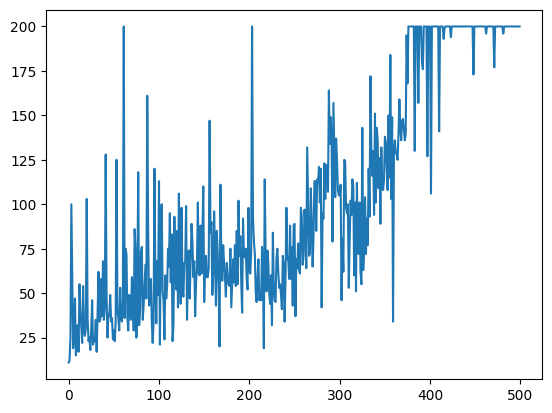

In [67]:
score_df['score'].plot()

In [68]:
score_df.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


trajectory       score
count  500.000000  500.000000
mean   249.500000  105.046000
std    144.481833   62.040454
min      0.000000   11.000000
25%    124.750000   54.750000
50%    249.500000   87.000000
75%    374.250000  165.000000
max    499.000000  200.000000

In [69]:
# obs_df1.groupby('trajectory')['reward'].size()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
obs_df1 = pd.merge(obs_df, score_df, on='trajectory')
obs_df1

trajectory  sequence   hor_pos  velocity  pole_angle  angular_velocity  \
0             0.0       0.0 -0.021992 -0.003885   -0.037828          0.002261   
1             0.0       1.0 -0.022070  0.191758   -0.037783         -0.302113   
2             0.0       2.0 -0.018235  0.387398   -0.043825         -0.606469   
3             0.0       3.0 -0.010487  0.583104   -0.055954         -0.912627   
4             0.0       4.0  0.001175  0.778937   -0.074207         -1.222358   
...           ...       ...       ...       ...         ...               ...   
53018       499.0     196.0  0.703863  0.383939   -0.060653         -0.323501   
53019       499.0     197.0  0.711542  0.579870   -0.067123         -0.634678   
53020       499.0     198.0  0.723139  0.385746   -0.079817         -0.363866   
53021       499.0     199.0  0.730854  0.191843   -0.087094         -0.097380   
53022       499.0     200.0  0.734691  0.388099   -0.089042         -0.416221   

       action  reward  score  
0         0.0     0.0     11  
1         1.0     1.0     11  
2         1.0     1.0     11  
3         1.0     1.0     11  
4         1.0     1.0     11  
...       ...     ...    ...  
53018     1.0     1.0    200  
53019     1.0     1.0    200  
53020     0.0     1.0    200  
53021     0.0     1.0    200  
53022     1.0     1.0    200  

[53023 rows x 9 columns]

In [71]:
obs_df1.groupby('trajectory').agg({'reward':'sum', 'score':'min'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


reward  score
trajectory               
0.0           11.0     11
1.0           12.0     12
2.0           25.0     25
3.0          100.0    100
4.0           59.0     59
...            ...    ...
495.0        200.0    200
496.0        200.0    200
497.0        200.0    200
498.0        200.0    200
499.0        200.0    200

[500 rows x 2 columns]

In [72]:
# obs_df1.head(60)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
obs_df.groupby('trajectory').size().describe()

count    500.000000
mean     106.046000
std       62.040454
min       12.000000
25%       55.750000
50%       88.000000
75%      166.000000
max      201.000000
dtype: float64

In [74]:
obs_df1.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


trajectory      sequence       hor_pos      velocity    pole_angle  \
count  53023.000000  53023.000000  53023.000000  53023.000000  53023.000000   
mean     321.989401     70.634574      0.356505      0.369431      0.050215   
std      135.021507     53.677593      0.521124      0.570274      0.076759   
min        0.000000      0.000000     -1.281903     -1.726838     -0.240302   
25%      223.000000     26.000000     -0.015048     -0.022318     -0.000673   
50%      361.000000     57.000000      0.150167      0.315892      0.048636   
75%      433.000000    106.500000      0.621036      0.714593      0.104415   
max      499.000000    200.000000      2.449940      2.729582      0.241010   

       angular_velocity        action        reward         score  
count      53023.000000  53023.000000  53023.000000  53023.000000  
mean           0.070926      0.517210      0.990570    141.269147  
std            0.348021      0.499708      0.096649     59.865507  
min           -1.965015      0.000000      0.000000     11.000000  
25%           -0.155906      0.000000      1.000000     85.000000  
50%            0.068590      1.000000      1.000000    147.000000  
75%            0.301446      1.000000      1.000000    200.000000  
max            2.018696      1.000000      1.000000    200.000000

In [75]:
obs_df1['successful'] = obs_df1['score'].apply(lambda x: x>195)
obs_df1['successful'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


successful
False    30118
True     22905
Name: count, dtype: int64

In [76]:
obs_df1.to_csv('observation_data_nov9.csv')
obs_df1.to_csv(output_folder+'observation_data_nov9.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Visualize time-series data: Plot the values of cart position, cart velocity, pole angle, and pole velocity over time. This can give you insights into how the system behaves dynamically.
1. Plot of x(t) vs. time.
2. Plot of v_c(t) vs. time.
3. Plot of θ(t) vs. time.
4. Plot of ω(t) vs. time.

-------------------- hor_pos --------------------
   hor_pos+ve  count
0        True  37501
1       False  15522


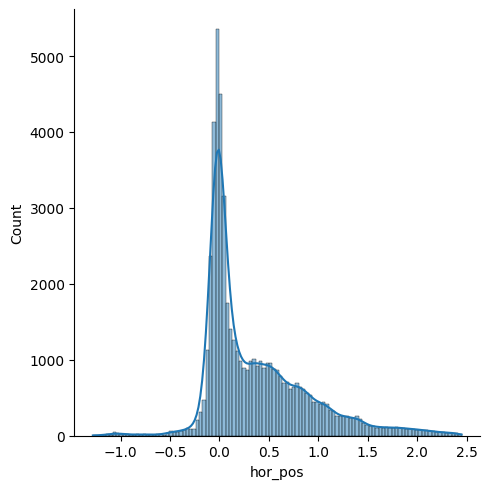

-------------------- velocity --------------------
   velocity+ve  count
0         True  38091
1        False  14932


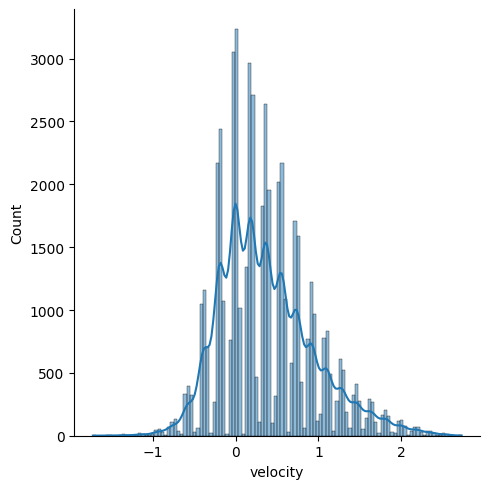

-------------------- pole_angle --------------------
   pole_angle+ve  count
0           True  39627
1          False  13396


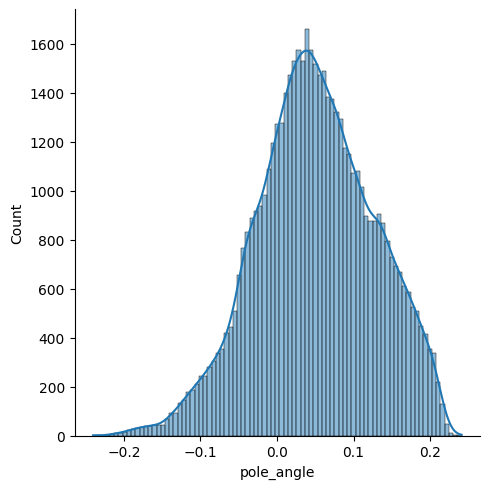

-------------------- angular_velocity --------------------
   angular_velocity+ve  count
0                 True  31145
1                False  21878


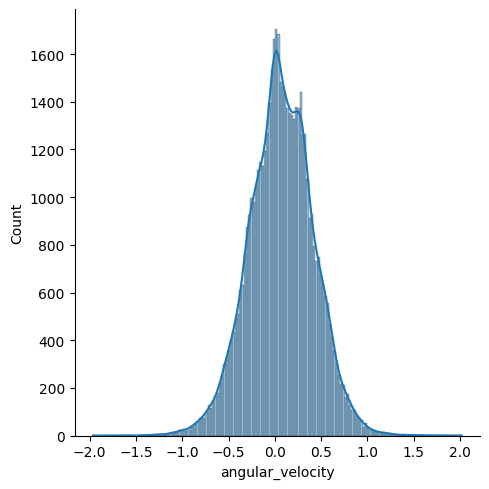

In [77]:


for inp_col in ['hor_pos','velocity','pole_angle','angular_velocity']:
  print('--'*10,inp_col,'--'*10)

  z =  obs_df1[inp_col].apply(lambda x: x>0).value_counts().reset_index()
  z.columns = [z.columns[0] + '+ve', z.columns[1]]
  print(z)
  # obs_df1[inp_col].plot(kind='hist')
  sns.displot( data=obs_df1[inp_col], kde=True )
  plt.show()

**Statistical analysis:**

Compute basic statistics (mean, median, standard deviation, min, max) for each of the variables. This will help you understand the central tendencies and spread of the data.

In [78]:
obs_df1 = pd.read_csv(output_folder+'observation_data_nov9.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
obs_df1['sequence_bin'] = pd.cut(obs_df1['sequence'], bins=40, include_lowest=True)
successful = obs_df1.loc[obs_df1['score']==200]
unsuccessful = obs_df1.loc[obs_df1['score']<200]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To interpret the results of a Mann-Whitney U test, you can compare the p-value to a chosen significance level, usually 0.05:
1. P-value ≤ α: The difference between the medians is statistically significant.
2. P-value > α: The difference between the medians is not statistically significant.

In [80]:
from scipy.stats import mannwhitneyu

def test_difference(df1,df2, col, alpha=0.05):
  print('--'*10,inp_col,'--'*10)
  U1, p = mannwhitneyu(df1[col], df2[col], method="auto")
  print(U1)
  print(p)
  if p > alpha:
    print('The difference between the medians is not statistically significant.')
  else:
    print('The difference between the medians is statistically significant.')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
for inp_col in ['hor_pos', 'velocity','pole_angle','angular_velocity']:
  test_difference(successful, unsuccessful, inp_col, alpha=0.05)

-------------------- hor_pos --------------------
466001479.5
0.0
The difference between the medians is statistically significant.
-------------------- velocity --------------------
305042670.5
2.29810374982192e-103
The difference between the medians is statistically significant.
-------------------- pole_angle --------------------
149086121.5
0.0
The difference between the medians is statistically significant.
-------------------- angular_velocity --------------------
273293504.5
0.0
The difference between the medians is statistically significant.


**Assumption of Interactions between observation / input variables:**




1.   The Cart Position influences the Pole Angle through forces exerted by the cart's movement, which can cause the pole to tilt.
2.   The Cart Velocity affects the Pole Angle and Pole Velocity at Tip by determining the speed at which the cart moves, which influences the dynamics of the pole.
3.   The Pole Angle and Pole Velocity at Tip are closely related because the tip's velocity depends on the angle and the angular velocity of the pole.




In [82]:
sample = obs_df1.sample(5000)

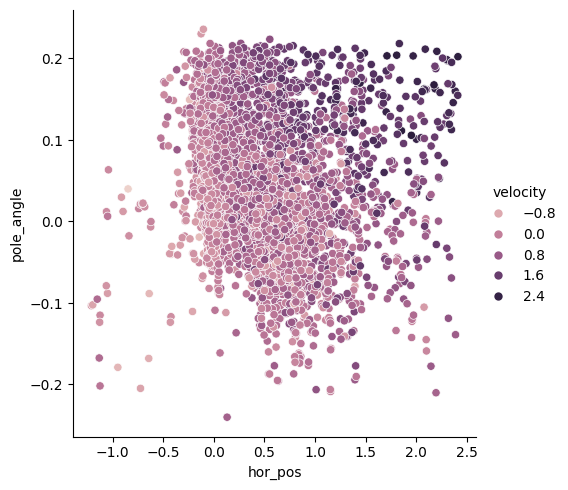

In [83]:
sns.relplot(data=sample, x="hor_pos", y="pole_angle", hue="velocity")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


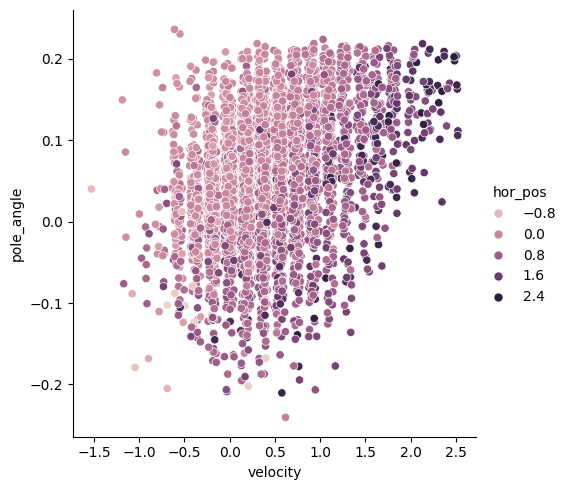

In [84]:
sns.relplot(data=sample, x="velocity", y="pole_angle",hue="hor_pos")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


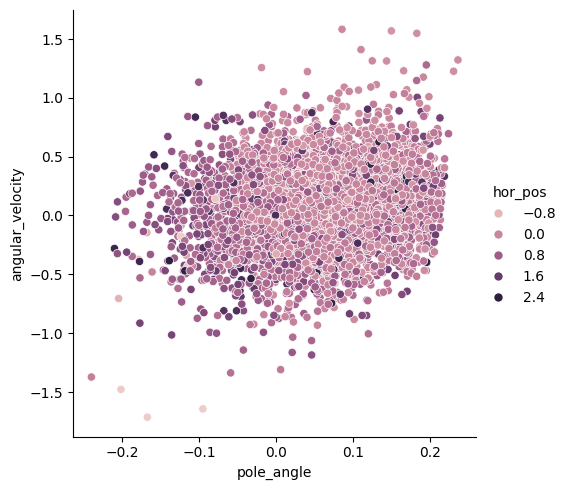

In [85]:
sns.relplot(data=sample, x="pole_angle", y="angular_velocity", hue="hor_pos")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


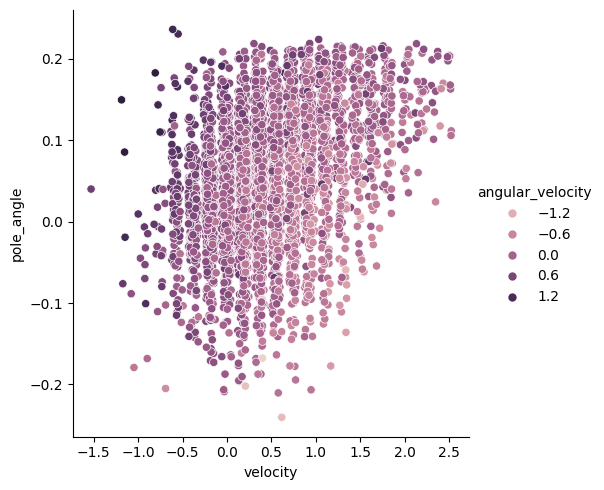

In [86]:
sns.relplot(data=sample, x="velocity", y="pole_angle",hue="angular_velocity")

In [87]:
sample.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Unnamed: 0', 'trajectory', 'sequence', 'hor_pos', 'velocity',
       'pole_angle', 'angular_velocity', 'action', 'reward', 'score',
       'successful', 'sequence_bin'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


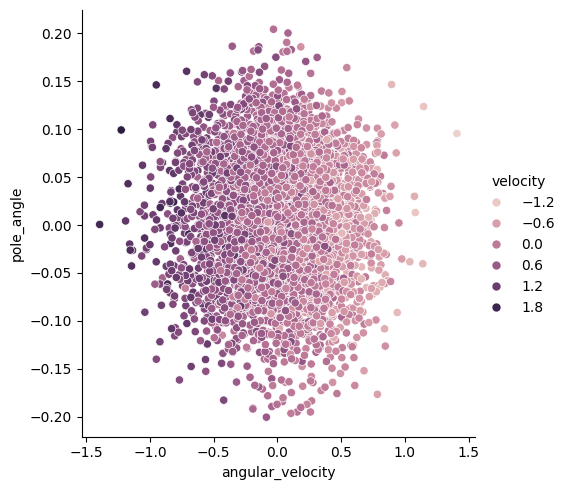

In [110]:
sns.relplot(data=successful.sample(5000), x="angular_velocity", y="pole_angle",hue="velocity")

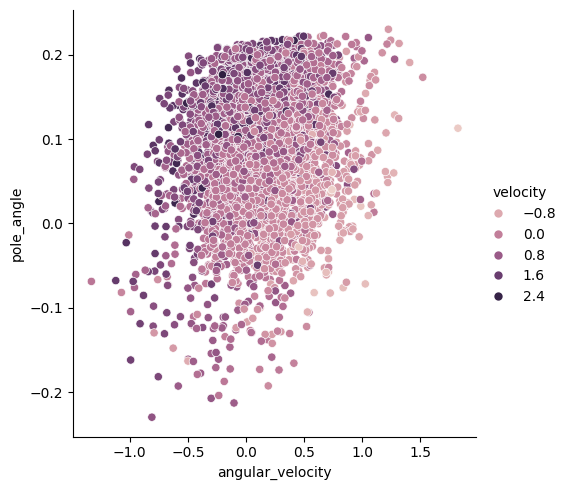

In [112]:
sns.relplot(data=unsuccessful.sample(5000), x="angular_velocity", y="pole_angle",hue="velocity")

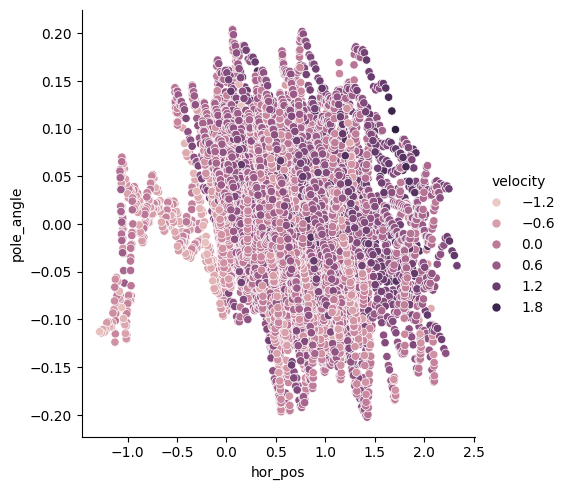

In [106]:
sns.relplot(data=successful, x="hor_pos", y="pole_angle",hue="velocity")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


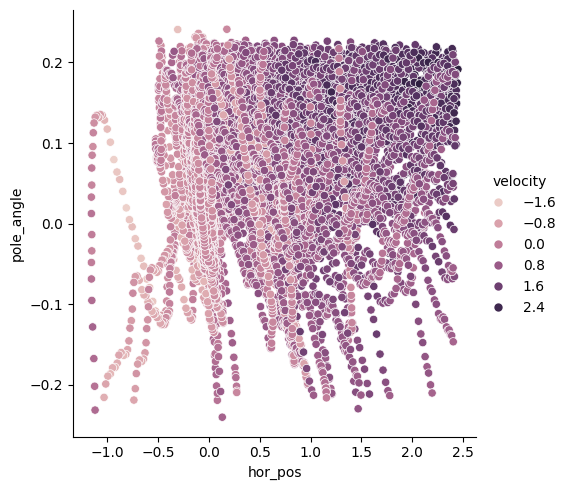

In [107]:
sns.relplot(data=unsuccessful, x="hor_pos", y="pole_angle",hue="velocity")


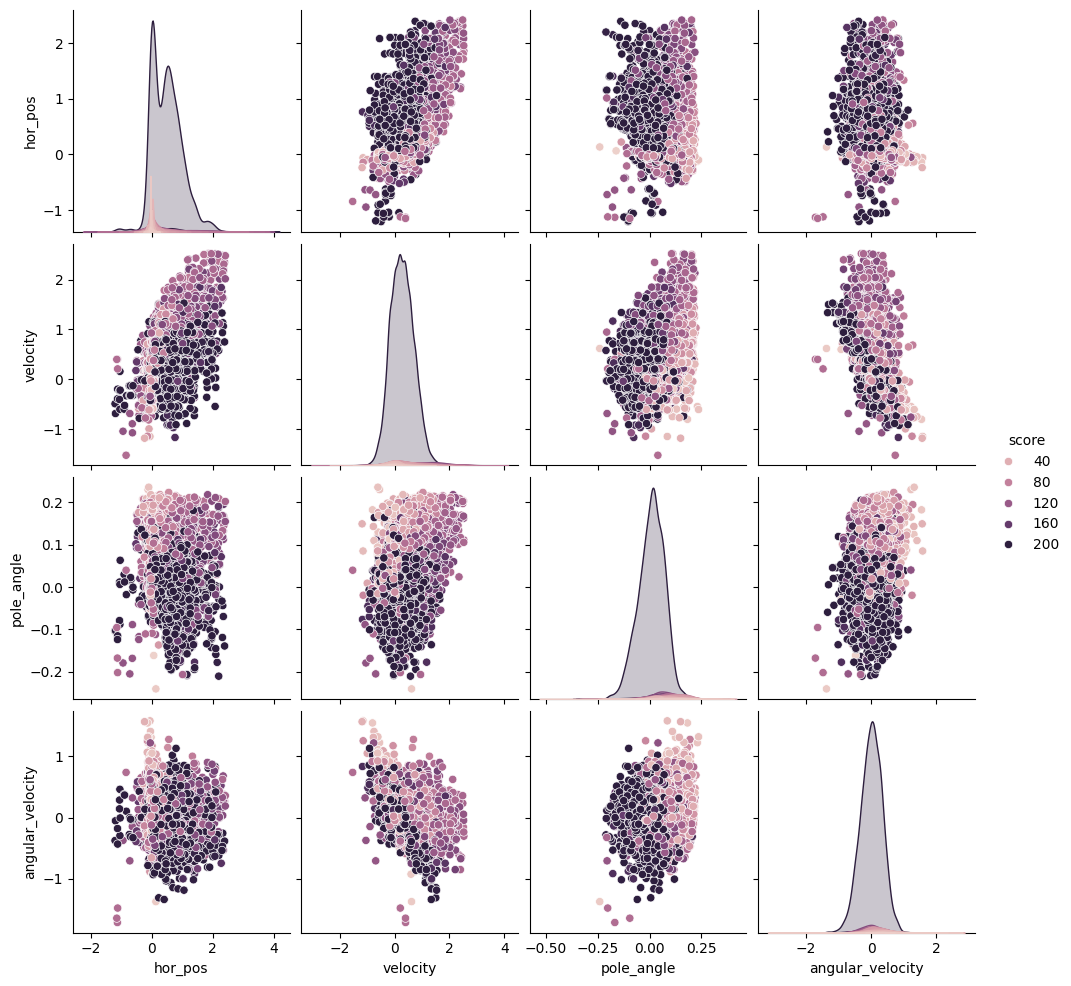

In [117]:
sns.pairplot(sample[[ 'hor_pos', 'velocity',
       'pole_angle', 'angular_velocity','score']], hue='score')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


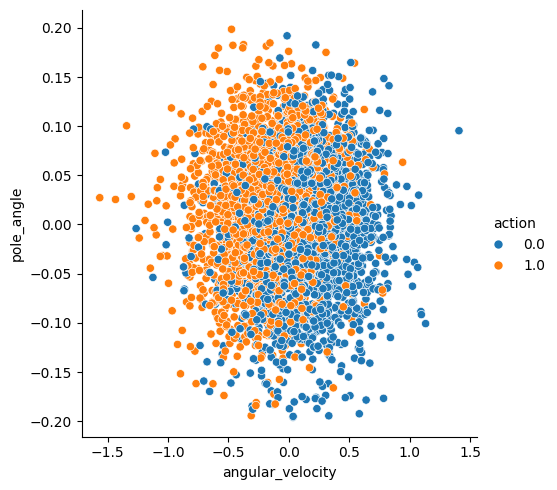

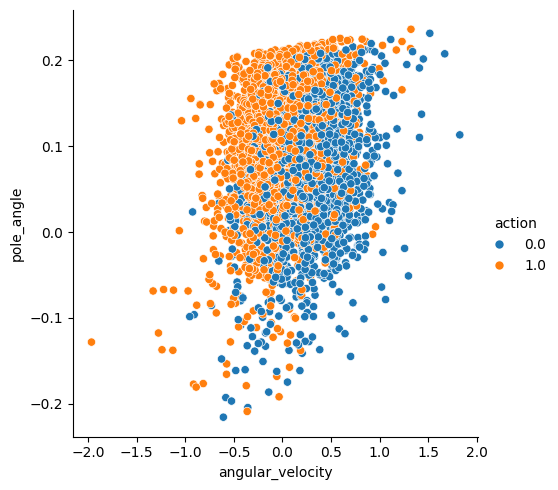

In [118]:
sns.relplot(data=successful.sample(5000), x="angular_velocity", y="pole_angle",hue="action")
sns.relplot(data=unsuccessful.sample(5000), x="angular_velocity", y="pole_angle",hue="action")
plt.show()

In [113]:
from sklearn import datasets, linear_model, metrics
reg = linear_model.LinearRegression()
reg.fit(obs_df1[[ 'hor_pos', 'velocity',
       'pole_angle', 'angular_velocity']], obs_df1['score'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LinearRegression()

In [115]:
# regression coefficients
print('Coefficients: ', reg.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(obs_df1[[ 'hor_pos', 'velocity',
       'pole_angle', 'angular_velocity']], obs_df1['score'])))

Coefficients:  [  48.05086424  -29.0569458  -225.79814961  -52.07093921]
Variance score: 0.36375476965574804


In [89]:
# pd.cut(obs_df1['sequence'], bins=40, include_lowest=True).unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
# sns.heatmap(obs_df1.pivot_table(index='trajectory', columns='sequence_bin', values='hor_pos',  aggfunc="mean"))

In [91]:
# sns.barplot(obs_df1.groupby('sequence_bin')['hor_pos'].mean().reset_index(),
#                x="sequence_bin", y="hor_pos", hue="hor_pos", legend=False)
# plt.xticks(rotation=90)
# plt.show()

<ipython-input-92-66664decb0a9>:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(obs_df1.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))


-------------------- hor_pos --------------------


<ipython-input-92-66664decb0a9>:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(successful.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))
<ipython-input-92-66664decb0a9>:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(unsuccessful.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))


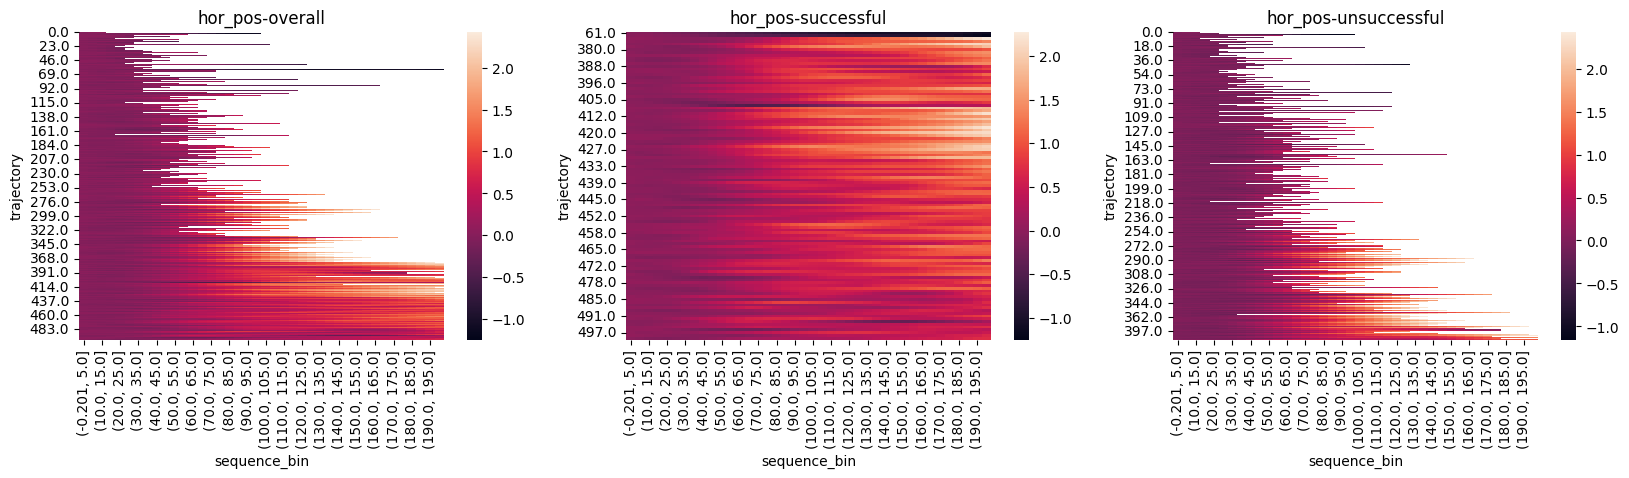

-------------------- velocity --------------------


<ipython-input-92-66664decb0a9>:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(obs_df1.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))
<ipython-input-92-66664decb0a9>:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(successful.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))
<ipython-input-92-66664decb0a9>:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(unsuccessful.pivot_table(index

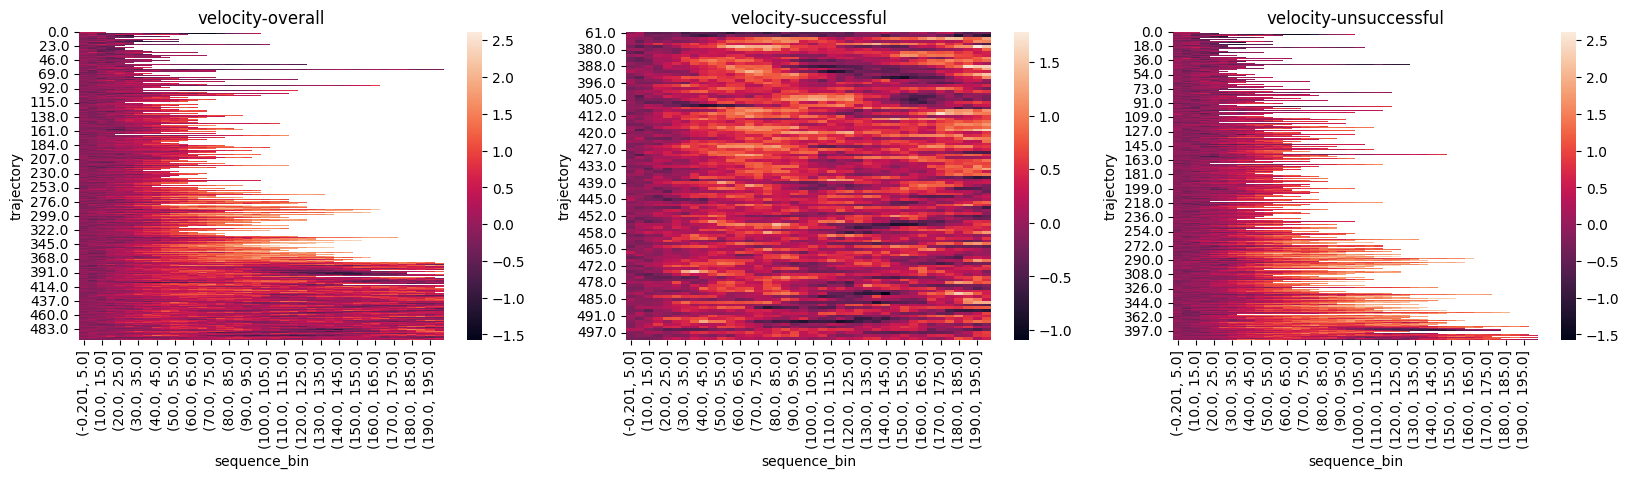

-------------------- pole_angle --------------------


<ipython-input-92-66664decb0a9>:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(obs_df1.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))
<ipython-input-92-66664decb0a9>:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(successful.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))
<ipython-input-92-66664decb0a9>:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(unsuccessful.pivot_table(index

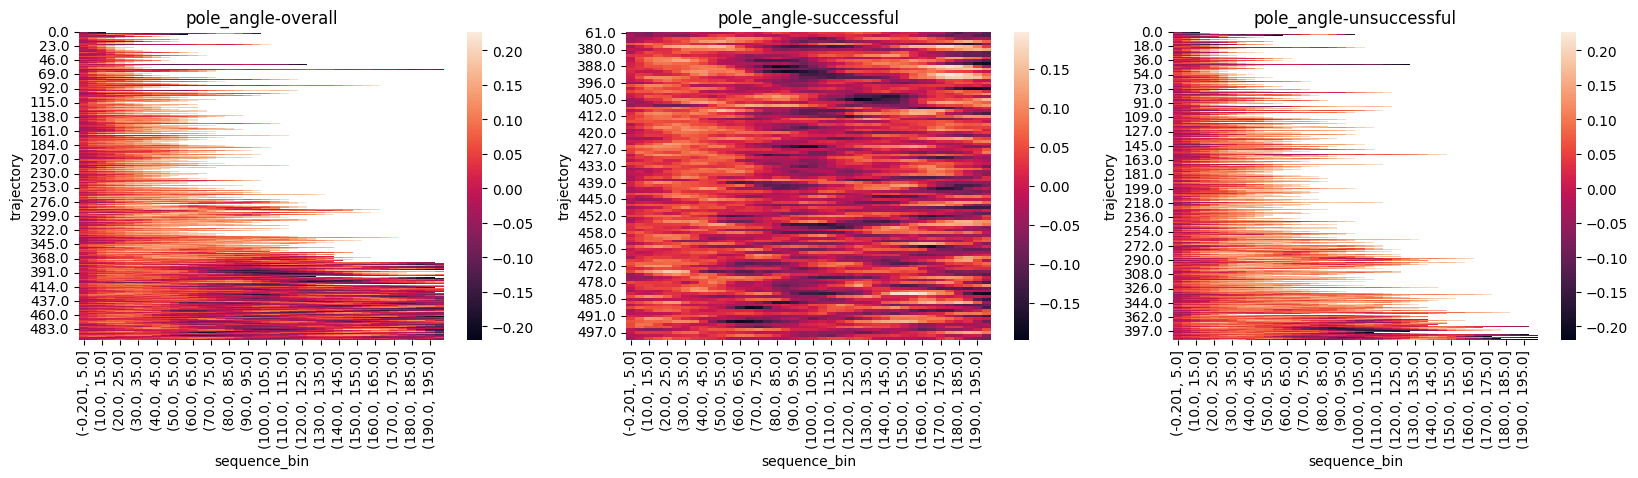

-------------------- angular_velocity --------------------


<ipython-input-92-66664decb0a9>:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(obs_df1.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))
<ipython-input-92-66664decb0a9>:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(successful.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))
<ipython-input-92-66664decb0a9>:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sns.heatmap(unsuccessful.pivot_table(index

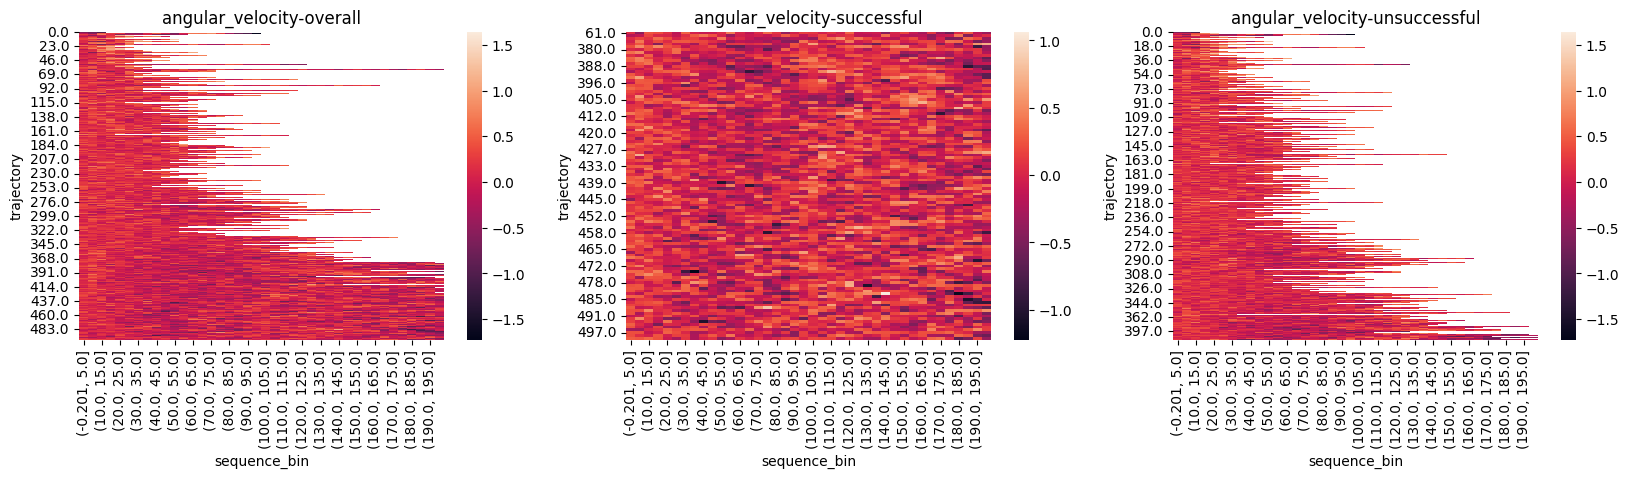

In [92]:

for inp_col in ['hor_pos', 'velocity','pole_angle','angular_velocity']:
  print('--'*10,inp_col,'--'*10)
  fig = plt.figure(figsize=(20, 4))

  plt.subplot(1, 3, 1)
  sns.heatmap(obs_df1.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))
  plt.title(inp_col + '-overall')
  plt.xticks(rotation=90)

  plt.subplot(1, 3, 2)
  sns.heatmap(successful.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))
  plt.title(inp_col + '-successful')
  plt.xticks(rotation=90)

  plt.subplot(1, 3, 3)
  sns.heatmap(unsuccessful.pivot_table(index='trajectory', columns='sequence_bin', values=inp_col, aggfunc='mean'))
  plt.title(inp_col + '-unsuccessful')
  plt.xticks(rotation=90)

  plt.show()

# Success vs Failure

- Successful scenarios have higher horizontal position compared to counterpart.
- Successful scenarios have lesser velocity compared to counterpart.
- Successful scenarios have lesser pole angle compared to counterpart.
- Successful scenarios have lesser angular velocity compared to counterpart.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-93-5f135b063c31>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(obs_df1.groupby('sequence_bin')[inp_col].mean().reset_index(),


-------------------- hor_pos --------------------


<ipython-input-93-5f135b063c31>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(successful.groupby('sequence_bin')[inp_col].mean().reset_index(),
<ipython-input-93-5f135b063c31>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(unsuccessful.groupby('sequence_bin')[inp_col].mean().reset_index(),


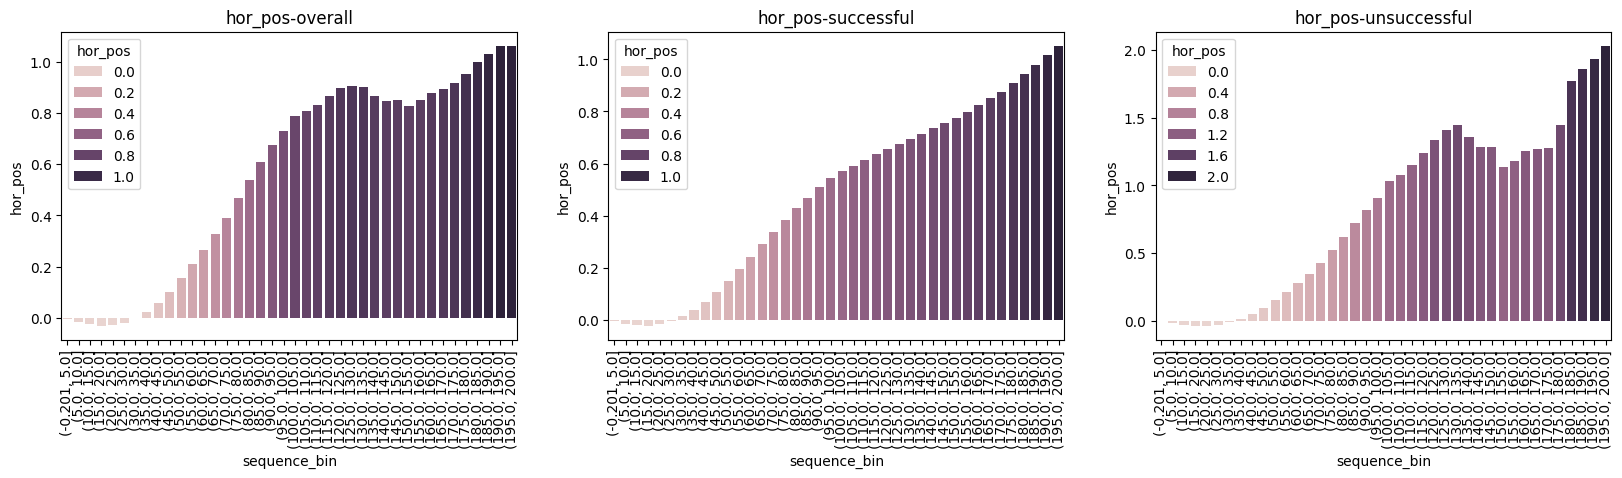

-------------------- velocity --------------------


<ipython-input-93-5f135b063c31>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(obs_df1.groupby('sequence_bin')[inp_col].mean().reset_index(),
<ipython-input-93-5f135b063c31>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(successful.groupby('sequence_bin')[inp_col].mean().reset_index(),
<ipython-input-93-5f135b063c31>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(unsuccessful.g

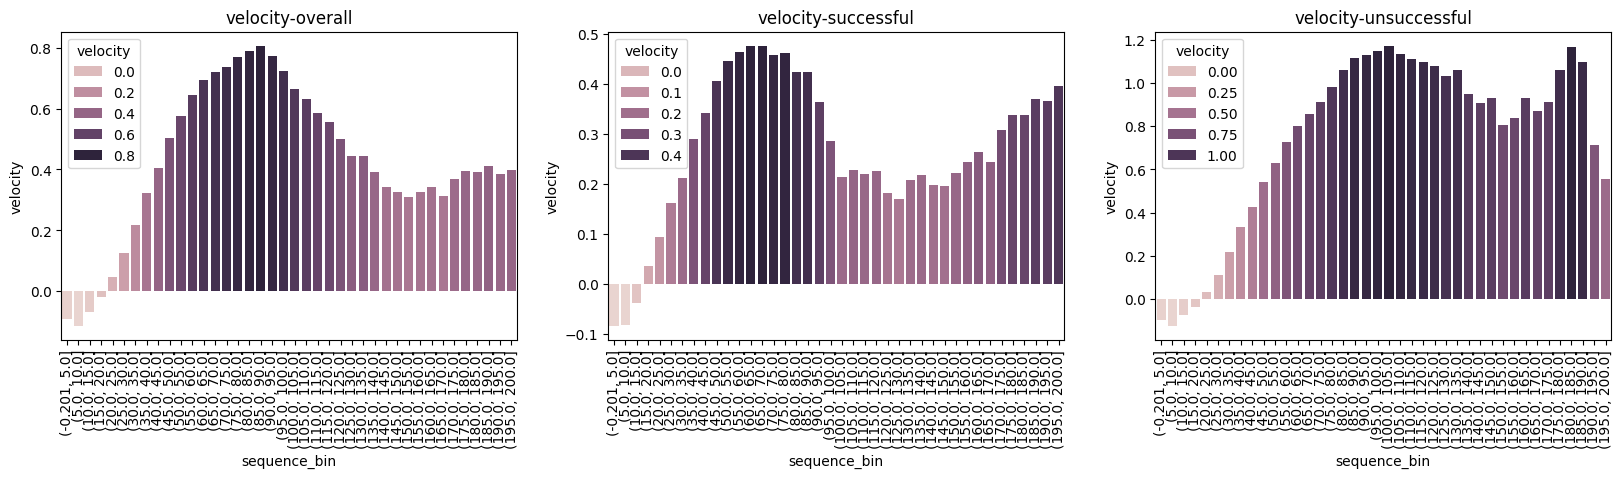

-------------------- pole_angle --------------------


<ipython-input-93-5f135b063c31>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(obs_df1.groupby('sequence_bin')[inp_col].mean().reset_index(),
<ipython-input-93-5f135b063c31>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(successful.groupby('sequence_bin')[inp_col].mean().reset_index(),
<ipython-input-93-5f135b063c31>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(unsuccessful.g

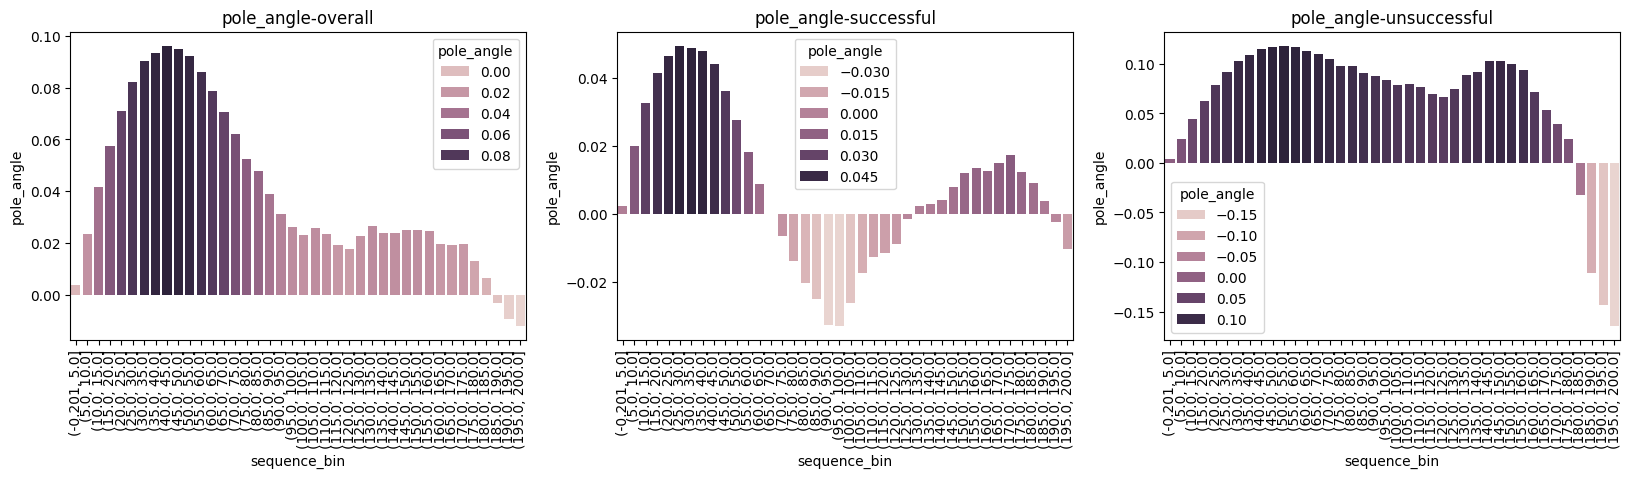

-------------------- angular_velocity --------------------


<ipython-input-93-5f135b063c31>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(obs_df1.groupby('sequence_bin')[inp_col].mean().reset_index(),
<ipython-input-93-5f135b063c31>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(successful.groupby('sequence_bin')[inp_col].mean().reset_index(),
<ipython-input-93-5f135b063c31>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(unsuccessful.g

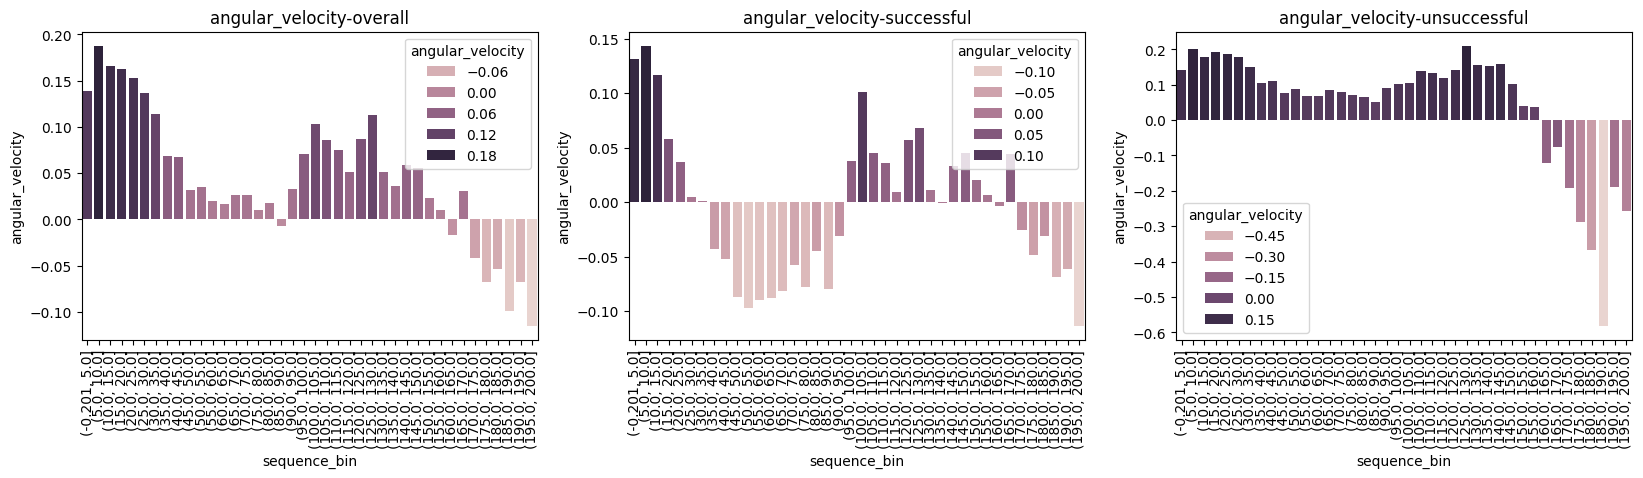

In [93]:
for inp_col in ['hor_pos', 'velocity','pole_angle','angular_velocity']:
  print('--'*10,inp_col,'--'*10)
  fig = plt.figure(figsize=(20, 4))

  plt.subplot(1, 3, 1)
  sns.barplot(obs_df1.groupby('sequence_bin')[inp_col].mean().reset_index(),
               x="sequence_bin", y=inp_col, hue=inp_col, legend=True)
  plt.title(inp_col + '-overall')
  plt.xticks(rotation=90)

  plt.subplot(1, 3, 2)
  sns.barplot(successful.groupby('sequence_bin')[inp_col].mean().reset_index(),
               x="sequence_bin", y=inp_col, hue=inp_col, legend=True)
  plt.title(inp_col + '-successful')
  plt.xticks(rotation=90)

  plt.subplot(1, 3, 3)
  sns.barplot(unsuccessful.groupby('sequence_bin')[inp_col].mean().reset_index(),
               x="sequence_bin", y=inp_col, hue=inp_col, legend=True)
  plt.title(inp_col + '-unsuccessful')
  plt.xticks(rotation=90)

  plt.show()

In [94]:
# successful = obs_df1.loc[obs_df1['score']==200]

# for inp_col in ['hor_pos', 'velocity','pole_angle','angular_velocity']:
#   print('--'*10,inp_col,'--'*10)
#   sns.barplot(successful.groupby('sequence_bin')[inp_col].mean().reset_index(),
#                x="sequence_bin", y=inp_col, hue=inp_col, legend=True)
#   plt.xticks(rotation=90)
#   plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
# obs_df1.groupby('trajectory').describe()

Plot the Scores

CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 17.5 ms


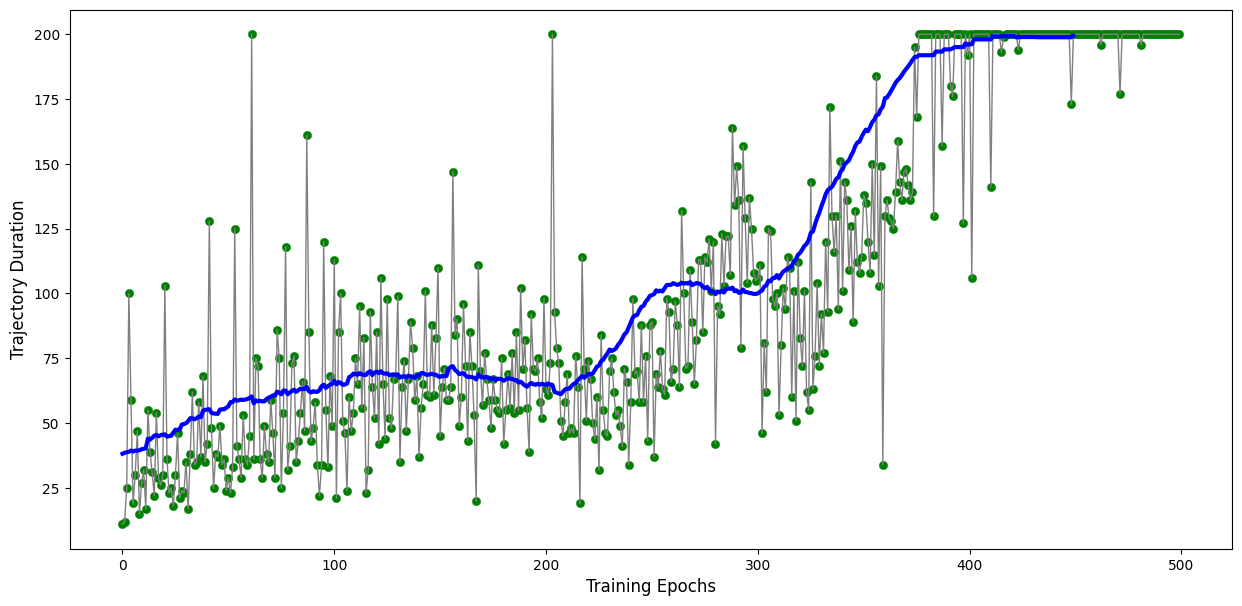

In [96]:
%%time

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

Render Cartpole Environment

In [97]:
%%time

# Configuration the image rendering in colab

# Taken from
# https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7

!apt-get install -y xvfb x11-utils &> /dev/null

!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.* &> /dev/null

!pip install gym[box2d]==0.17.* &> /dev/null

# Taken from https://github.com/actions/virtual-environments/issues/214
!sudo apt-get update  &> /dev/null
!sudo apt-get install xvfb --fix-missing &> /dev/null

import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

!echo $DISPLAY # sanity checking: should be set to some value (e.g. 1005)

from IPython import display

:1005
CPU times: user 152 ms, sys: 21 ms, total: 173 ms
Wall time: 15.7 s


Reward: 200.0
CPU times: user 21.7 s, sys: 178 ms, total: 21.8 s
Wall time: 32.9 s


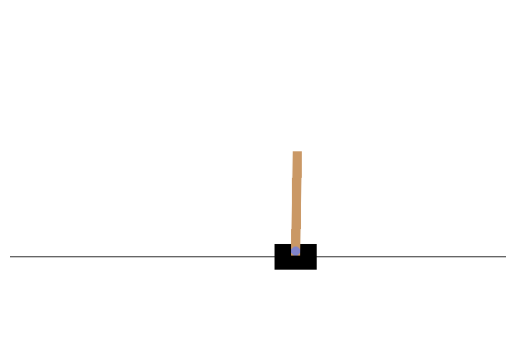

In [98]:
%%time

def watch_agent():
  env = gym.make('CartPole-v0')
  state = env.reset()
  rewards = []
  img = plt.imshow(env.render(mode='rgb_array'))
  for t in range(2000):
    pred = model(torch.from_numpy(state).float())
    action = np.random.choice(np.array([0,1]), p=pred.data.numpy())

    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        print("Reward:", sum([r for r in rewards]))
        break
  env.close()

watch_agent()

In [99]:
# watch_agent()

In [100]:
def test_agent():
  env = gym.make('CartPole-v0')
  state = env.reset()
  rewards = []
  obs=[]
  for t in range(2000):
    pred = model(torch.from_numpy(state).float())
    prev_state = state
    action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
    state, reward, done, _ = env.step(action)
    obs.append([prev_state,state,action])

    rewards.append(reward)
    if done:
      rew = sum([r for r in rewards])
      print("Reward:", rew)
      break
  env.close()


test_agent()

Reward: 200.0


In [101]:
# test_agent()

In [102]:
# test_agent()

In [103]:
for i in range(100):
  test_agent()

Reward: 200.0
Reward: 200.0
Reward: 185.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 172.0
Reward: 200.0
Reward: 200.0
Reward: 156.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 83.0
Reward: 200.0
Reward: 139.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 173.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 167.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: 200.0
Reward: